<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

import numpy as np

sys.path.append('../')
from batchers import batcher, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from utils.general import load_npz

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = '2009-17'
LABEL_NAME = 'wealthpooled'

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

SIZES = dataset_constants.SIZES[DATASET_NAME]

# Load histograms (or create if needed)

In [4]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [5]:
def get_batcher(tfrecord_files):
    return batcher.Batcher(
        tfrecord_files=tfrecord_files,
        dataset=DATASET_NAME,
        batch_size=128,
        ls_bands='ms',
        nl_band='merge',
        label_name=LABEL_NAME,
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)

In [6]:
file_path = '../data/image_hists_dhs.npz'

if not os.path.exists(file_path):
    # THIS REQUIRES >= 35 GB RAM
    tfrecord_paths = batcher.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
    init_iter, batch_op = get_batcher(tfrecord_paths).get_batch()
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)

In [7]:
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Split NL band

In [8]:
# split NL band
image_hists = split_nl_hist(image_hists, years)

## Plot histograms

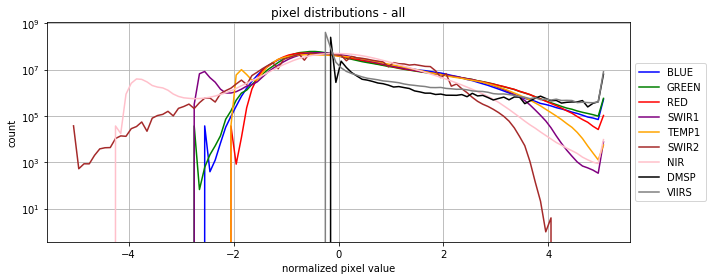

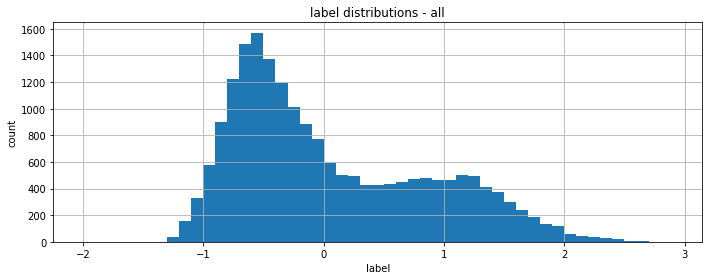

In [9]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')
plot_label_hist(labels, bin_edges=LABEL_BIN_EDGES, title='label distributions - all')